# Particle Localization

We build a neural network to determine the position of microscopic particles within an image.

## Load Data

We use a dataset including two videos of optically trapped particles.

In [1]:
import os

if not os.path.exists("particle_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/particle_dataset")

We define the `load_video` function to load the videos, save it in `fnc_particle_localization.py` ...

```python
def load_video(path, frames_to_load, image_size):
    import cv2
    import numpy as np

    video = cv2.VideoCapture(path)

    data = []
    for _ in range(frames_to_load):
        (_, frame) = video.read()
        frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255
        frame = cv2.resize(frame, (image_size, image_size))
        data.append(frame)

    return np.array(data)
```

... and use it to read the data.

In [2]:
from fnc_particle_localization import load_video

image_size = 51
video_low_noise = load_video(os.path.join("particle_dataset", "high_noise.avi"),
                             frames_to_load=100, image_size=image_size)
video_high_noise = load_video(os.path.join("particle_dataset", "low_noise.avi"),
                              frames_to_load=100, image_size=image_size)

We plot the first 5 frames of each video.

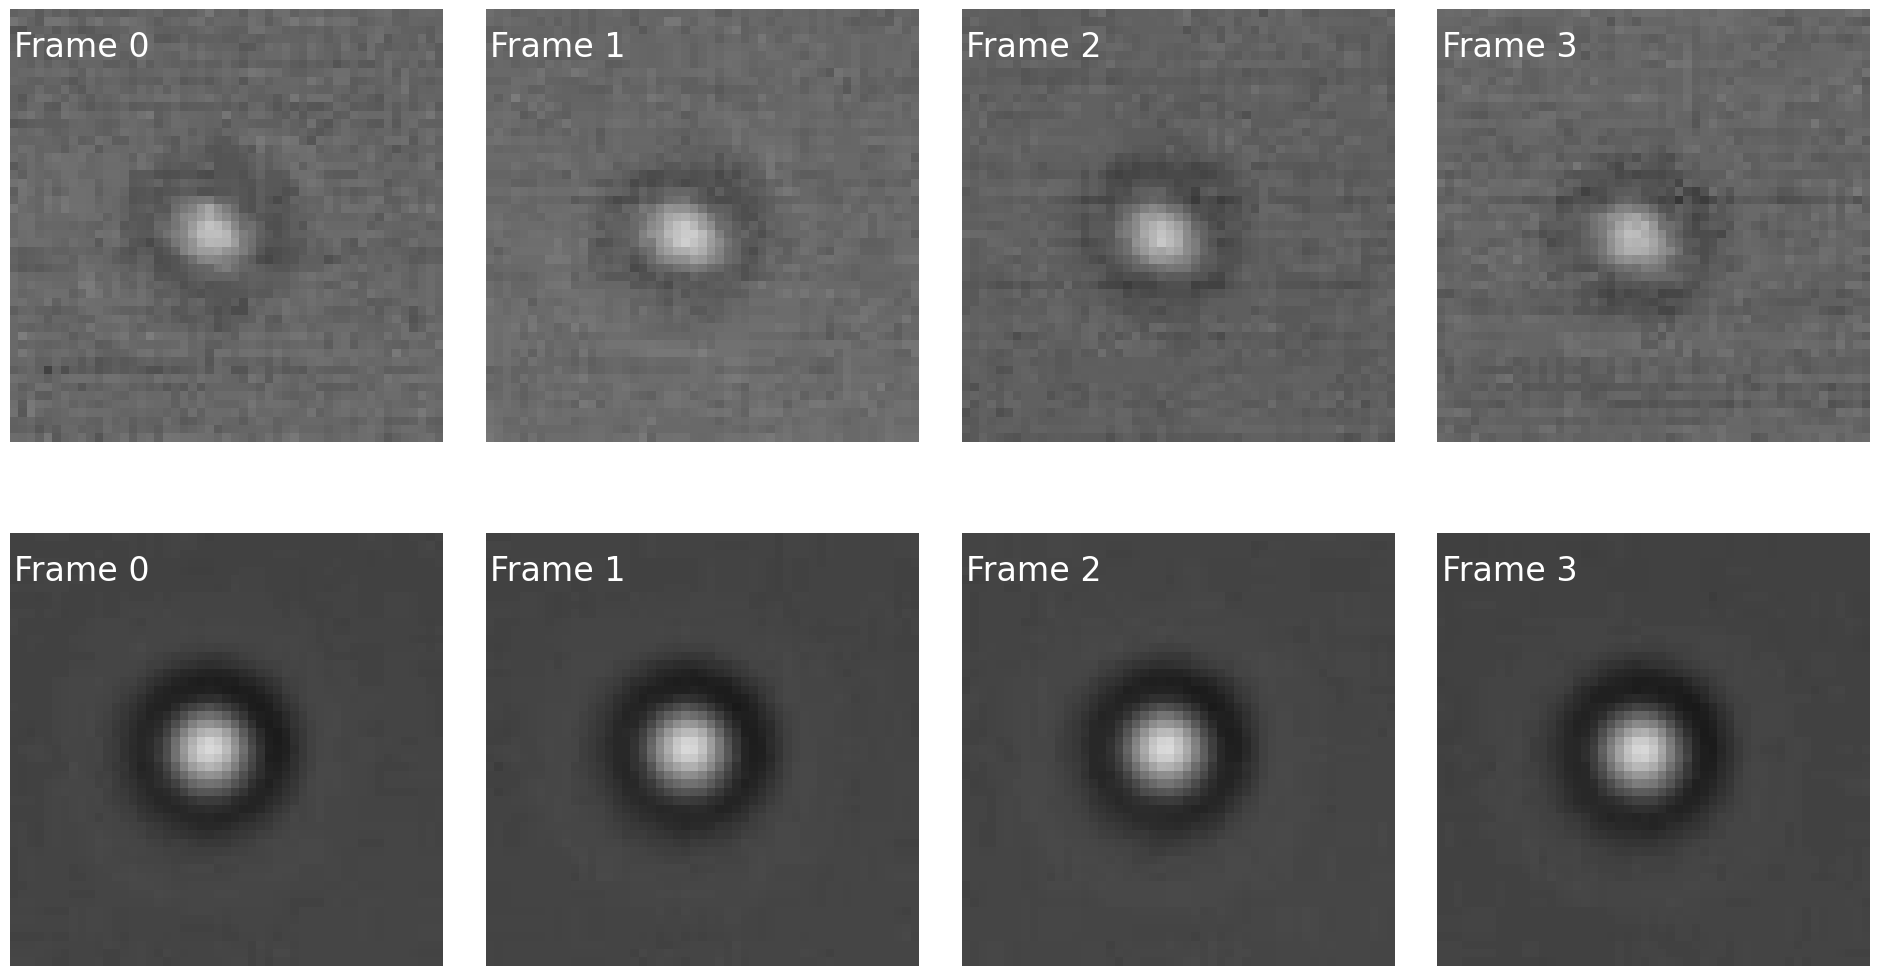

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 4, figsize=(24, 13))
for i in range(4):
    axs[0, i].imshow(video_low_noise[i], cmap="gray", vmin=0, vmax=1)
    axs[0, i].text(0, 5, f"Frame {i}", color="white", fontsize=24)
    axs[0, i].axis("off")
    
    axs[1, i].imshow(video_high_noise[i], cmap="gray", vmin=0, vmax=1)
    axs[1, i].text(0, 5, f"Frame {i}", color="white", fontsize=24)
    axs[1, i].axis("off")

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

## Annotate Data Manually

We define a class to be able to interactively select the centroid of particles in some of the video frames.

```python
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor

class ManualAnnotation:
    def __init__(self, images):
        self.images = images
        self.positions = []
        self.i = 0
        self.fig, self.ax = plt.subplots(1, 1, figsize=(5, 5))
        self.fig.canvas.header_visible = False
        self.fig.canvas.footer_visible = False

    def start(self):
        self.im = self.ax.imshow(self.images[self.i], cmap="gray", vmin=0, vmax=1)
        self.text = self.ax.text(
            3, 
            5, 
            f"Frame {self.i + 1} of {len(self.images)}", 
            color="white", 
            fontsize=12,
        )
        self.ax.axis("off")
        self.cursor = Cursor(self.ax, useblit=True, color="red", linewidth=1)
        self.cid = self.fig.canvas.mpl_connect("button_press_event", self.onclick)
        self.next_image()
        plt.show()

    def next_image(self):
        self.im.set_data(self.images[self.i])
        self.text.set_text(f"Frame {self.i + 1} of {len(self.images)}")
        self.fig.canvas.draw_idle()

    def onclick(self, event):
        self.positions.append([event.xdata, event.ydata])
        if self.i < len(self.images) - 1:
            self.i += 1
            self.next_image()
        else:
            self.fig.canvas.mpl_disconnect(self.cid)
            plt.close()
            return
```

We randomly select `number_of_images_to_annotate` frames and ask you to manually pinpoint the particle center.

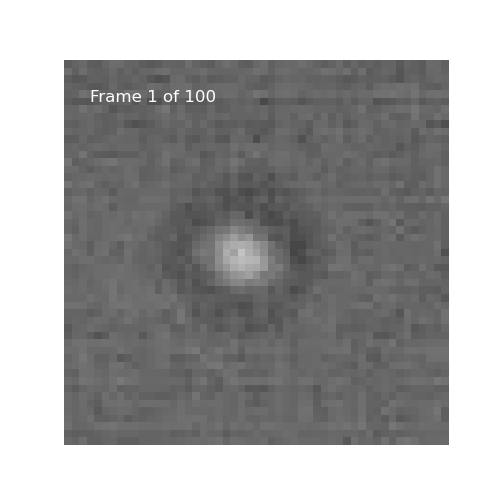

In [4]:
%matplotlib ipympl 
# Needed for using the interactive features of matplotlib in Notebooks

import numpy as np
from fnc_particle_localization import ManualAnnotation

number_of_images_to_annotate = 100

dataset = np.concatenate([video_low_noise, video_high_noise], axis=0)
np.random.shuffle(dataset)

images_to_annotate = np.random.choice(
  np.arange(dataset.shape[0]),
  number_of_images_to_annotate,
  replace=False,
)

manual_annotation = ManualAnnotation(dataset[images_to_annotate])

manual_annotation.start()

annotated_images = manual_annotation.images
manual_positions = manual_annotation.positions

# Back to normal matplotlib backend
%matplotlib inline

We save the annotated images and the corresponding centroid positions in two files.

In [5]:
file_images = os.path.join("particle_dataset", "annotated_images.npy")
np.save(file_images, np.array(annotated_images))

file_positions = os.path.join("particle_dataset", "manual_positions.npy")
np.save(file_positions, np.array(manual_positions))

## Preprocess Dataset

We use the annotated data to train and test a CNN. First, we define a `Dataset` class to provide the data in the needed format.

```python
import numpy as np
import torch
from torch.utils.data import Dataset

class ParticleDataset(Dataset):
    def __init__(self, file_images, file_positions):
        self.images = np.load(file_images)
        self.positions = np.load(file_positions)

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        im = torch.tensor(self.images[idx, np.newaxis, :, :]).float()
        pos = torch.tensor(self.positions[idx] / im.shape[-1] - .5).float()
        sample = [im, pos]
        return sample
```

The `ParticleDataset` class reads the annotated data, transform the images into torch tensors and rescales the centroid positions in [-1.1].

In [6]:
from fnc_particle_localization import ParticleDataset

ann_dataset = ParticleDataset(file_images, file_positions)

We split the annotated data and define two data loaders.

In [7]:
import deeplay as dl
from torch.utils.data import random_split

train_ann_dataset, test_ann_dataset = random_split(ann_dataset, [0.8, 0.2])

train_ann_dataloader = dl.DataLoader(train_ann_dataset, batch_size=1)
test_ann_dataloader = dl.DataLoader(test_ann_dataset, batch_size=1)

## Convolutional Neural Network

We define a CNN with a dense top to analyze the images using `deeplay`.

In [8]:
import torch.nn as nn

cnn = dl.Sequential(
    dl.ConvolutionalNeuralNetwork(
        in_channels=1,
        hidden_channels=[16, 32],
        out_channels=64,
        pool=nn.MaxPool2d(kernel_size=2),
        out_activation=nn.ReLU,
    ),
    dl.Layer(nn.MaxPool2d, kernel_size=2),
    dl.Layer(nn.Flatten),
    dl.MultiLayerPerceptron(
        in_features=6 * 6 * 64,
        hidden_features=[32, 32],
        out_features=2,
        out_activation=nn.Identity,
    ),
)

print(cnn)

Sequential(
  (0): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=64)
      )
      (1): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=64)
      )
      (2): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identit

We then compile the CNN as a regressor.

In [9]:
import torchmetrics as tm

regressor_template = dl.Regressor(
    model=cnn,
    loss=nn.MSELoss(),
    optimizer=dl.Adam(),
    metrics=[tm.MeanAbsoluteError()],
)

cnn_ann_regressor = regressor_template.create()

## Train

We train the CNN regressor...

In [10]:
cnn_ann_trainer = dl.Trainer(max_epochs=50, accelerator="auto")
cnn_ann_trainer.fit(cnn_ann_regressor, train_ann_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
2023-12-12 22:09:42.339601: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | Sequenti

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


... and evaluate its performance over the training set. We also calculate the mean absolute error in pixel units.

In [11]:
test_ann_results = cnn_ann_trainer.test(cnn_ann_regressor, test_ann_dataloader)

MAE_ann = test_ann_results[0]["testMeanAbsoluteError_epoch"] * image_size
print(f"Mean pixel error (MAE): {MAE_ann:.3f} pixels")

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Test metric               DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
testMeanAbsoluteError_epoch   0.005925983190536499
      test_loss_epoch         5.212519317865372e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Mean pixel error (MAE): 0.302 pixels


## Visualize Predictions

We compare annotated and predicted particle positions.

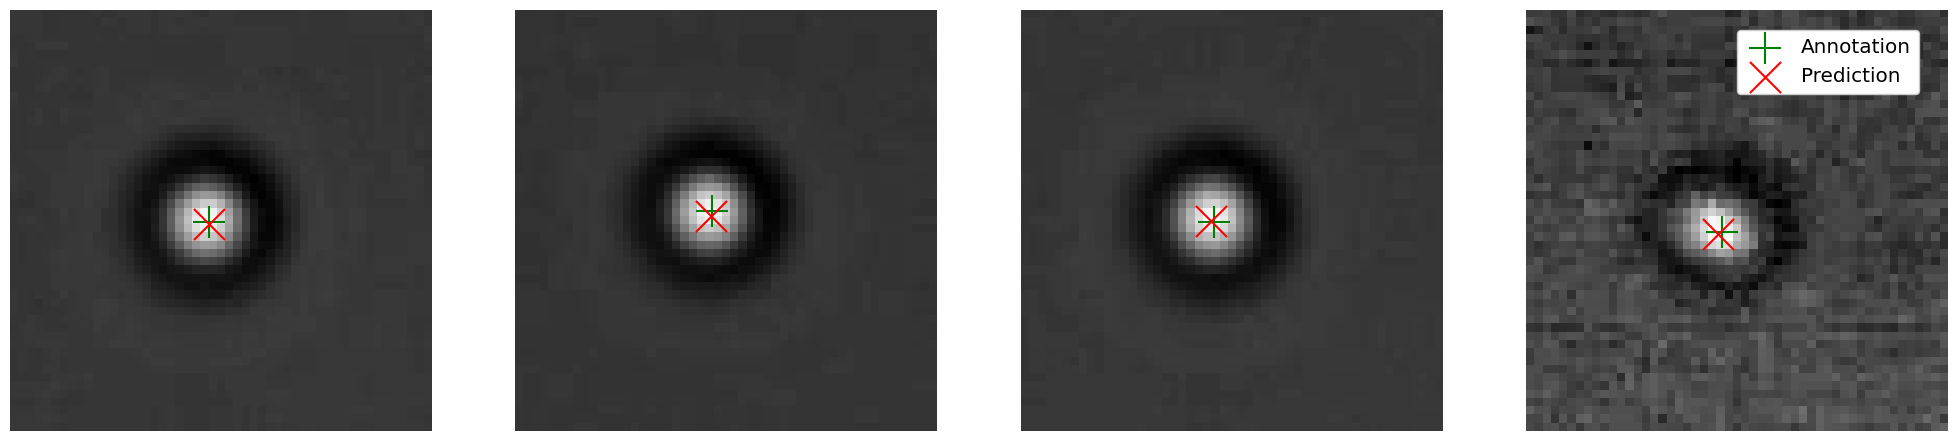

In [13]:
import torch

indices = np.random.choice(np.arange(len(test_ann_dataset)), 4, replace=False)
images = [test_ann_dataset[index][0] for index in indices]
annotations = [test_ann_dataset[index][1] for index in indices]
predictions = cnn_ann_regressor(torch.stack(images))

fig, axes = plt.subplots(1, 4, figsize=(25, 12))
for ax, im, ann, pred in zip(axes, images, annotations, predictions):
    ax.imshow(im.numpy().squeeze(), cmap="gray")
    
    ann = ann * image_size + image_size / 2
    ax.scatter(ann[0], ann[1], marker="+", c="g", s=500, label="Annotation")
    
    pred = pred.detach().numpy() * image_size + image_size / 2
    ax.scatter(pred[0], pred[1], marker="x", c="r", s=500, label="Prediction")

    ax.set_axis_off()

ax.legend(loc=(0.5, 0.8), framealpha=1, fontsize='x-large')
plt.show()


## Image simulations

We will use the `deeptrack` library to simulate particle images for which the ground truth is known. In these way, we avoid the manual annotation and can have more data available for training.

The particle is defined using the deeptrack object `MieSphere`.

In [14]:
from deeptrack.scatterers import MieSphere

particle = MieSphere(
    position=(25, 25),
    z=0,
    radius=500e-9,
    refractive_index=1.37,
    position_unit="pixel",
)

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/deeptrack/backend/_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Then, we specify the optical device to image the particle.

In [15]:
from deeptrack.optics import Brightfield

brightfield_microscope = Brightfield(
    wavelength=630e-9,
    NA=0.8,
    resolution=1e-6,
    magnification=15,
    refractive_index_medium=1.33,
    output_region=(0, 0, image_size, image_size),
)

We create the image of the particle and display it.

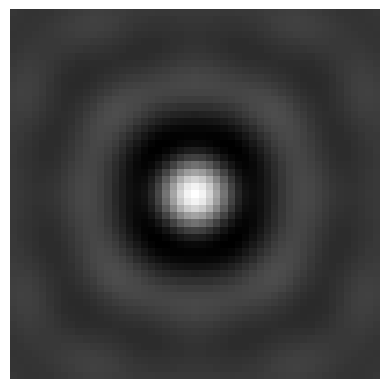

In [16]:
imaged_particle = brightfield_microscope(particle)

fig = plt.figure()
plt.imshow(np.squeeze(imaged_particle.resolve()), cmap="gray")
plt.axis("off")
plt.show()

We create particles with random positions around the center and display them.

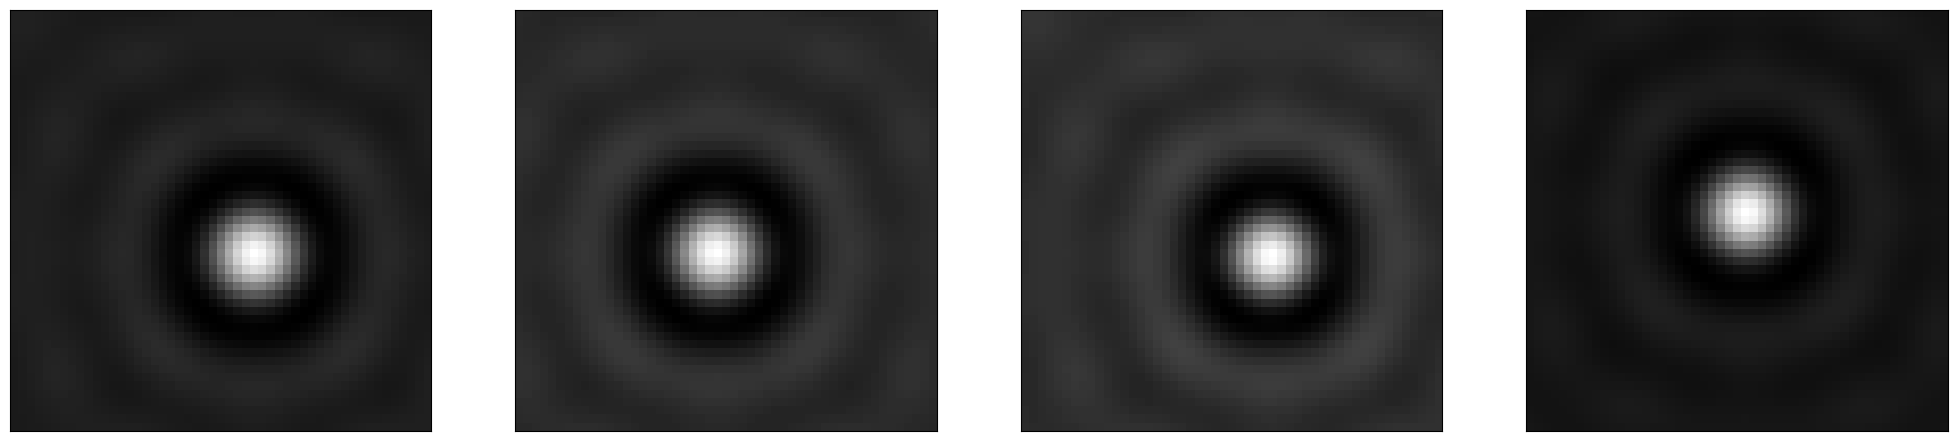

In [17]:
particle = MieSphere(
    position=lambda: np.random.uniform(image_size / 2 - 5, image_size / 2 + 5, 2),
    z=lambda: np.random.uniform(-1, -1),
    radius=lambda: np.random.uniform(500, 600) * 1e-9,
    refractive_index=lambda: np.random.uniform(1.37, 1.42),
    position_unit="pixel",
)
imaged_particle = brightfield_microscope(particle)

fig, axes = plt.subplots(1, 4, figsize=(25, 12))
for i, ax in enumerate(axes.flatten()):
    output_image = imaged_particle.update().resolve()
    ax.imshow(np.squeeze(output_image), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

We also add some Poisson noise to make the images more realistic.

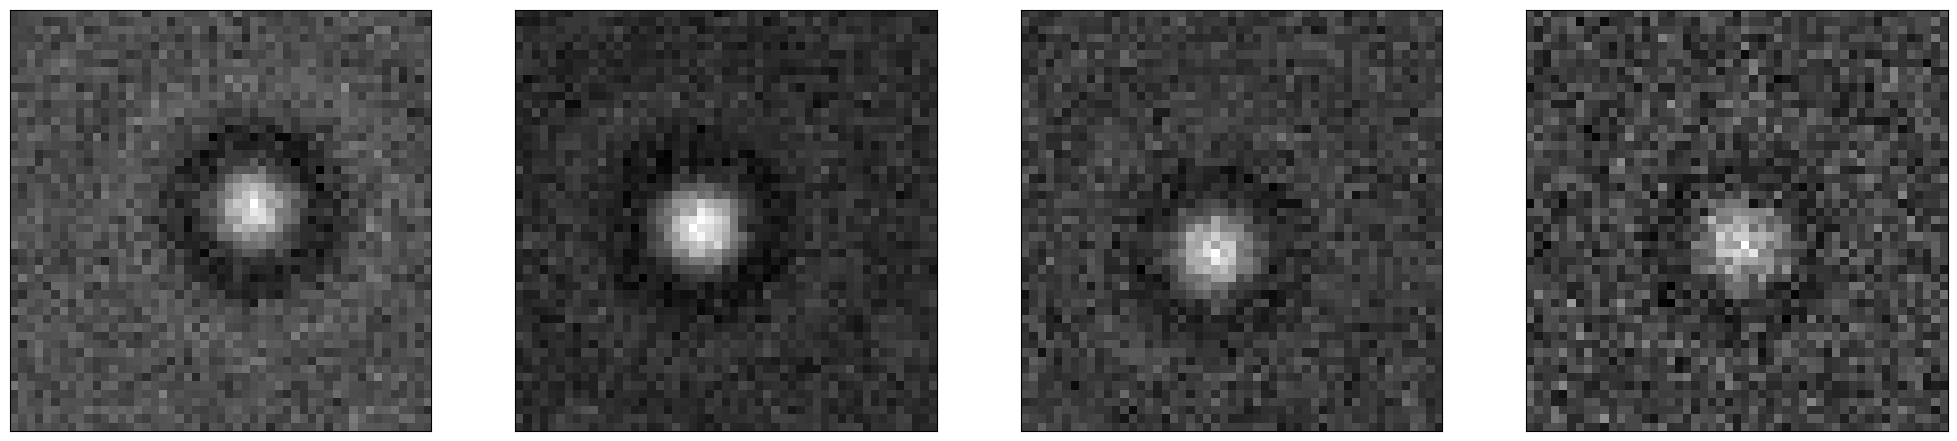

In [18]:
from deeptrack import Poisson

noise = Poisson(
    min_snr=5,
    max_snr=20,
    snr=lambda min_snr, max_snr: min_snr + np.random.rand() * (max_snr - min_snr),
    background=1,
)

noisy_imaged_particle = imaged_particle >> noise

fig, axes = plt.subplots(1, 4, figsize=(25, 12))
for i, ax in enumerate(axes.flatten()):
    output_image = noisy_imaged_particle.update().resolve()
    ax.imshow(np.squeeze(output_image), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

Finally, we create a pipeline that generates noisy particle images and normalize the pixel values. 

In [19]:
from deeptrack import NormalizeMinMax

normalization = NormalizeMinMax(
    lambda: np.random.rand() * 0.2, lambda: 0.8 + np.random.rand() * 0.2
)
data_pipeline = noisy_imaged_particle >> normalization

We also define a function to exctract the particle centroid position from the image
```python
def get_label(image):
    from numpy import array

    position = array(image.get_property("position"))
    
    return position
```
We display some images with the corresponding ground truth position.

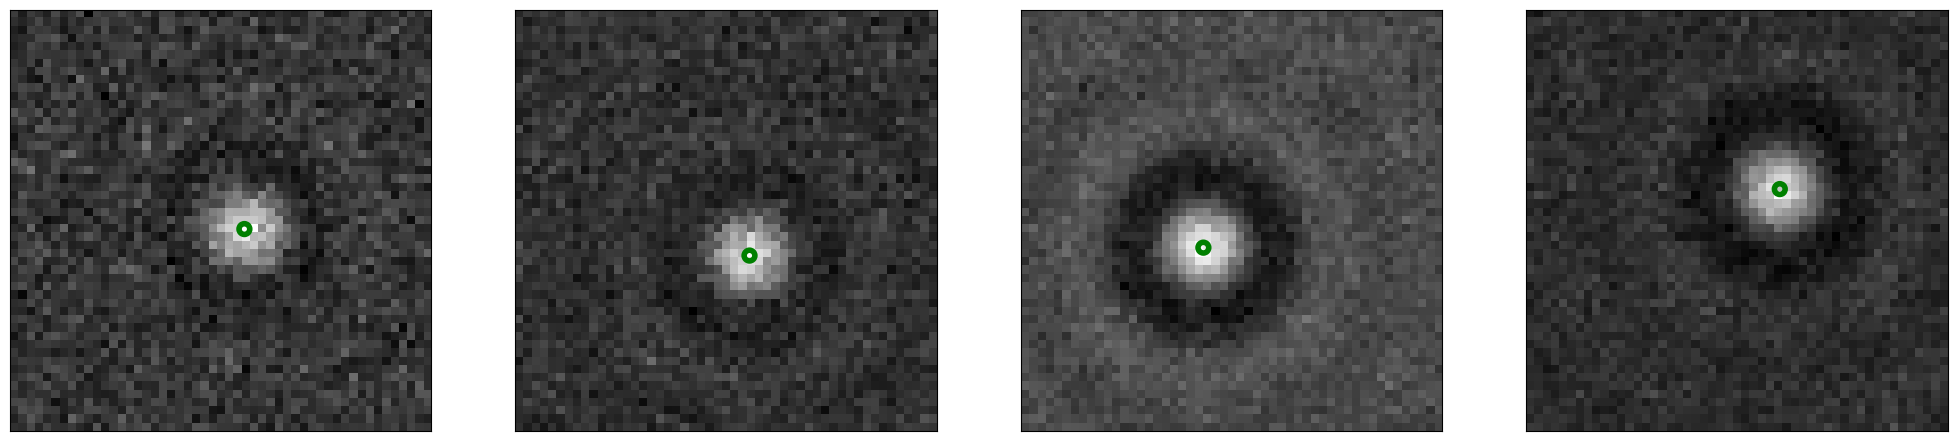

In [20]:
from fnc_particle_localization import get_label

fig, axes = plt.subplots(1, 4, figsize=(25, 12))

for i, ax in enumerate(axes.flatten()):
    output_image = data_pipeline.update().resolve()
    ax.imshow(np.squeeze(output_image), cmap="gray")

    particle_position = get_label(output_image)
    ax.scatter(
        particle_position[1],
        particle_position[0],
        s=60,
        facecolors="none",
        edgecolor="g",
        linewidth=4,
    )

    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

We want to use the simulations for the CNN training. Thus, we modify the class `ParticleDataset` to now work with the simulation pipeline, creating the new class `SimulatedDataset`
```python
class SimulatedDataset(Dataset):
    def __init__(self, pipeline, data_size):
        im = [pipeline.update().resolve() for _ in range(data_size)]
        self.pos = np.array([get_label(image) for image in im])[:, [1, 0]]
        self.im = np.array(im).squeeze()

    def __len__(self):
        return self.im.shape[0]

    def __getitem__(self, idx):
        img = torch.tensor(self.im[idx, np.newaxis, :, :]).float()
        labels = torch.tensor(self.pos[idx] / img.shape[-1] - 0.5).float()
        sample = [img, labels]
        return sample
```
The class can be used with the data loader and passed to the CNN for training.

In [21]:
from fnc_particle_localization import SimulatedDataset

train_sim_dataloader = dl.DataLoader(
    SimulatedDataset(pipeline=data_pipeline, data_size=10000), batch_size=32
)

cnn_sim_regressor = regressor_template.create()
cnn_sim_trainer = dl.Trainer(max_epochs=50, accelerator="auto")
cnn_sim_trainer.fit(cnn_sim_regressor, train_sim_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | Sequential       | 98.2 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
98.2 K    Trainable params
0         Non-trainable params
98.2 K    Total params
0.393     Total estimated model params size (MB)
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pyto

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


We check the network performance on a simulated test dataset...

In [22]:
test_sim_dataloader = dl.DataLoader(
    SimulatedDataset(pipeline=data_pipeline, data_size=100), batch_size=32
)

test_sim_results = cnn_sim_trainer.test(cnn_sim_regressor, test_sim_dataloader)

MAE_sim = test_sim_results[0]["testMeanAbsoluteError_epoch"] * image_size
print(f"Mean pixel error (MAE): {MAE_sim:.3f} pixels")

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Test metric               DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
testMeanAbsoluteError_epoch   0.001767170848324895
      test_loss_epoch         5.257745669950964e-06
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Mean pixel error (MAE): 0.090 pixels


... and plot the predictions versus the ground truth.

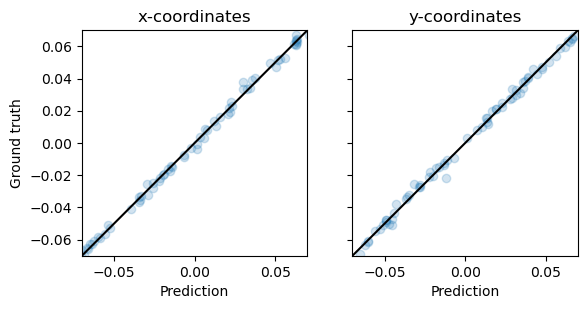

In [23]:
pred, gt = [], []
for batch in iter(test_sim_dataloader):
    pred.append(cnn_sim_regressor(batch[0]))
    gt.append(batch[1])
pred = torch.cat(pred, dim=0).detach().numpy()
gt = torch.cat(gt, dim=0).numpy()

fig, axs = plt.subplots(1, 2)
for i, ax, coordinate in zip([0, 1], axs, ["x", "y"]):
    label = gt[:][:, i]
    prediction = pred[:][:, i]
    ax.scatter(label, prediction, alpha=0.2)
    ax.plot([np.min(label), np.max(label)], [np.min(label), np.max(label)], c="k")
    ax.set_title(f"{coordinate}-coordinates")
    ax.set_xlabel("Prediction"), ax.set_ylabel("Ground truth")
    ax.set_aspect("equal"), ax.set_xlim([-.07, .07]), ax.set_ylim([-.07, .07])
    ax.label_outer()

plt.show()

Let's check now the CNN predictions on the annotated test dataset.

In [24]:
test_ann_results_with_cnn_sim = cnn_sim_trainer.test(cnn_sim_regressor, 
                                                     test_ann_dataloader)

MAE_ann_with_cnn_sim = (test_ann_results_with_cnn_sim[0]
                        ["testMeanAbsoluteError_epoch"] * image_size)
print(f"Mean pixel error (MAE): {MAE_ann_with_cnn_sim:.3f} pixels")

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Test metric               DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
testMeanAbsoluteError_epoch   0.004791115410625935
      test_loss_epoch         3.783124338951893e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Mean pixel error (MAE): 0.244 pixels


Last, we plot the predictions in comparison to the annotations.

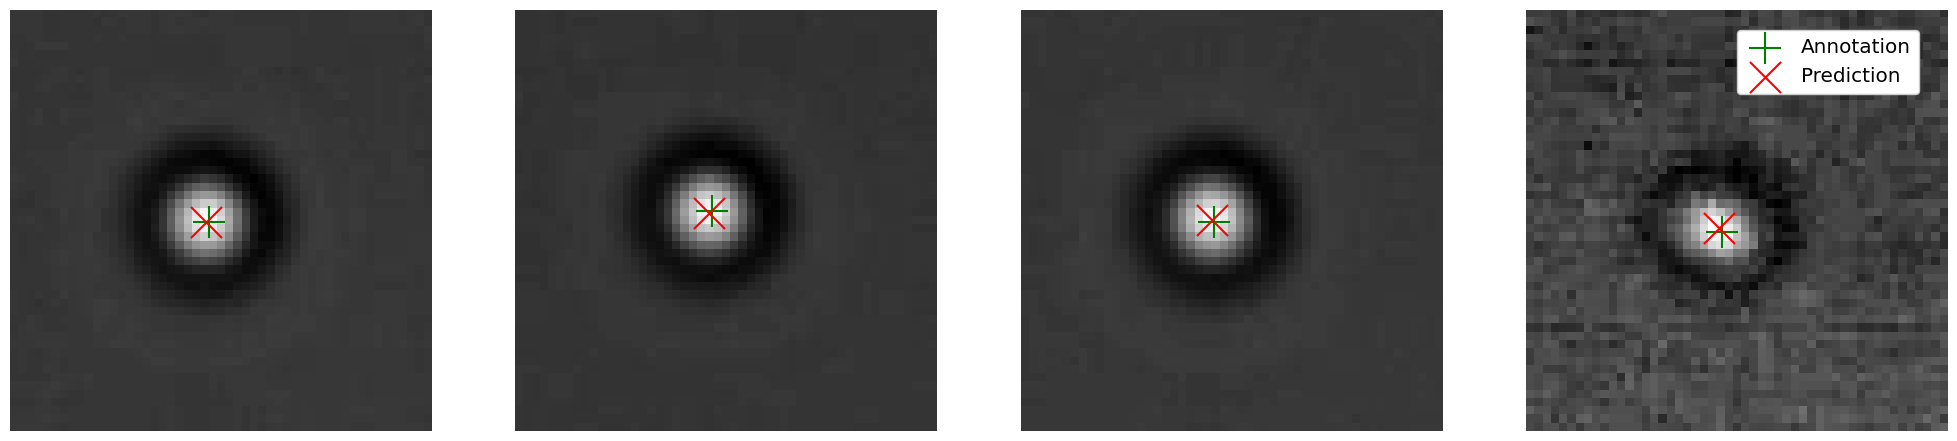

In [25]:
images = [test_ann_dataset[index][0] for index in indices]
annotations = [test_ann_dataset[index][1] for index in indices]
predictions = cnn_sim_regressor(torch.stack(images))

fig, axes = plt.subplots(1, 4, figsize=(25, 12))
for ax, im, ann, pred in zip(axes, images, annotations, predictions):
    ax.imshow(im.numpy().squeeze(), cmap="gray")
    
    ann = ann * image_size + image_size / 2
    ax.scatter(ann[0], ann[1], marker="+", c="g", s=500, label="Annotation")
    
    pred = pred.detach().numpy() * image_size + image_size / 2
    ax.scatter(pred[0], pred[1], marker="x", c="r", s=500, label="Prediction")

    ax.set_axis_off()

ax.legend(loc=(0.5, 0.8), framealpha=1, fontsize='x-large')
plt.show()
